![header](./images/header2.jpg)

## Predicting Customer Churn using Classification Machine Learning

**Author**: [Nate Kist](mailto:natekist@outlook.com)


## Overview

I analyzed a database of customer data from SyriaTel to determine which customers were churning the most and to predict if a customer was likely to churn soon.  Correct prediction of this type of binary classification can be used by SyriaTel as an early warning system indicating customers at risk of leaving.  From there, SyriaTel can then make business decisions of what to offer its at risk customers in the form of incentives to stay.  

It was found that customers from Maryland, New Jersey, and Texas were churning the most.  Similarly, customers with international plans and customers with 5 or more customer service calls were churning at higher rates.  It was recommended that SyriaTel look into the real-world drivers of these identified issues.  

In the end, I created a classification model that correctly predicted churn with 96% accuracy.  It was recommended that SyriaTel implement this model in its active marketing strategy to prevent loss of customers.  

## Business Understanding

SyriaTel, a US-based telecommunications company, asked me (Nate Kist, of CRM Consulting) to perform an analysis on its customer data to:
1. Provide insight on groups of customers that are churning at higher rates, and
2. Create a model that can predict whether a customer will churn.

## Data Understanding

#### Imports

In [1]:
# Data/numerical analysis libriaries
import pandas as pd
import numpy as np

# Visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

#### Functions and Constants

In [2]:
# Train / test / split: test size.  
test_size = .35

def cross_val_and_print_results_on_model(model_name,pipe, X_tr, y_tr, X_te, y_te):
    results = cross_val_score(pipe, X_tr, y_tr, cv=10)
    y_hat = pipe.fit(X_tr, y_tr).predict(X_te)
    print(model_name + ":")
    print(f"Training data - accuracy:          {round(np.mean(results), 4)}")
    print(f"Test data - accruacy:              {round(accuracy_score(y_te, y_hat), 4)}")
    matrix=classification_report(y_te, y_hat)
    print("Classification report:\n", matrix)
    
    
def grid_search_and_print_results(params, pipe, X_tr, y_tr, X_te, y_te):
    gs = GridSearchCV(estimator=pipe,param_grid=params, cv=5, verbose=1)
    gs.fit(X_tr, y_tr)
    print("Results:")
    print("- Best params: ", gs.best_params_)
    print("- Best score: ", gs.best_score_)
    print("- Test data score: ", gs.best_estimator_.score(X_te, y_te))

#### Importing data

In [3]:
df = pd.read_csv('data/bigml_59c28831336c6604c800002a.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


#### Data review and cleaning

Review and fix the feature names to be more code friendly. 

In [4]:
# View column names
df.columns

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')

In [5]:
# Rename columns
df.columns = df.columns.str.replace(" ", "_")
df.columns

Index(['state', 'account_length', 'area_code', 'phone_number',
       'international_plan', 'voice_mail_plan', 'number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls', 'churn'],
      dtype='object')

Check out the features we have and if there are any null values.

In [6]:
df

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,...,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,...,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,...,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,...,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,...,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False


Check out the values in each feature to see what type of data each really is.

In [7]:
for x in df.columns:
    print(df[x].value_counts())        

WV    106
MN     84
NY     83
AL     80
OR     78
WI     78
OH     78
VA     77
WY     77
CT     74
VT     73
MI     73
ID     73
TX     72
UT     72
IN     71
KS     70
MD     70
MT     68
NC     68
NJ     68
NV     66
WA     66
CO     66
MS     65
RI     65
MA     65
AZ     64
MO     63
FL     63
ND     62
ME     62
NM     62
DE     61
NE     61
OK     61
SD     60
SC     60
KY     59
IL     58
NH     56
AR     55
GA     54
DC     54
HI     53
TN     53
AK     52
LA     51
PA     45
IA     44
CA     34
Name: state, dtype: int64
105    43
87     42
93     40
101    40
90     39
       ..
191     1
199     1
215     1
221     1
2       1
Name: account_length, Length: 212, dtype: int64
415    1655
510     840
408     838
Name: area_code, dtype: int64
336-7155    1
404-5387    1
344-5181    1
393-3635    1
407-6748    1
           ..
351-4616    1
407-2718    1
404-4421    1
350-8921    1
353-5714    1
Name: phone_number, Length: 3333, dtype: int64
no     3010
yes     323
Name: internati

Review numerical field statistics

In [8]:
df.describe()

,account_length,area_code,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


Check for nulls

In [9]:
df.isna().sum()

state                     0
account_length            0
area_code                 0
phone_number              0
international_plan        0
voice_mail_plan           0
number_vmail_messages     0
total_day_minutes         0
total_day_calls           0
total_day_charge          0
total_eve_minutes         0
total_eve_calls           0
total_eve_charge          0
total_night_minutes       0
total_night_calls         0
total_night_charge        0
total_intl_minutes        0
total_intl_calls          0
total_intl_charge         0
customer_service_calls    0
churn                     0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account_length          3333 non-null   int64  
 2   area_code               3333 non-null   int64  
 3   phone_number            3333 non-null   object 
 4   international_plan      3333 non-null   object 
 5   voice_mail_plan         3333 non-null   object 
 6   number_vmail_messages   3333 non-null   int64  
 7   total_day_minutes       3333 non-null   float64
 8   total_day_calls         3333 non-null   int64  
 9   total_day_charge        3333 non-null   float64
 10  total_eve_minutes       3333 non-null   float64
 11  total_eve_calls         3333 non-null   int64  
 12  total_eve_charge        3333 non-null   float64
 13  total_night_minutes     3333 non-null   float64
 14  total_night_calls       3333 non-null   

Notes:
- No nulls.  No need to impute anything.  
- 3333 rows.  21 columns.  
- Ignore phone number. y will be churn series. Everything else will be in X.  

## Data Preparation

#### Figure out feature types

Assign columns to either continous numerical or categorical feature list.  We will use these lists later when we transform columns. 

In [11]:
X_numeric_cols = ['account_length','number_vmail_messages',
       'total_day_minutes', 'total_day_calls', 'total_day_charge',
       'total_eve_minutes', 'total_eve_calls', 'total_eve_charge',
       'total_night_minutes', 'total_night_calls', 'total_night_charge',
       'total_intl_minutes', 'total_intl_calls', 'total_intl_charge',
       'customer_service_calls']
X_categorical_cols = ['state', 'area_code','international_plan', 'voice_mail_plan']
X_ignore_cols = ['phone_number']
y_target_col = 'churn'

#### Train-test-split of the data

Prevent leakage by splitting the data before doing anything related to modeling.

In [12]:
X = df.drop(X_ignore_cols + [y_target_col], axis=1)
y = df[y_target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=test_size)

In [13]:
df.churn.value_counts(normalize=True)

False    0.855086
True     0.144914
Name: churn, dtype: float64

This seems to be imbalanced.  Plan on using SMOTE to oversample the minority class later on. 

#### Create column transformer pipelines

Create column transformer that scales continuous numerical features and encodes categorical features.

In [14]:
# Numerical column transformers
num_pipe = Pipeline([('ss',StandardScaler())])

# Categorical column transformers
cat_pipe = Pipeline([
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])
CT = ColumnTransformer(transformers=[
    ('num_trans', num_pipe, X_numeric_cols),
    ('cat_trans', cat_pipe, X_categorical_cols)
],remainder='passthrough')

## Exploratory Data Analysis 

### Churn by State

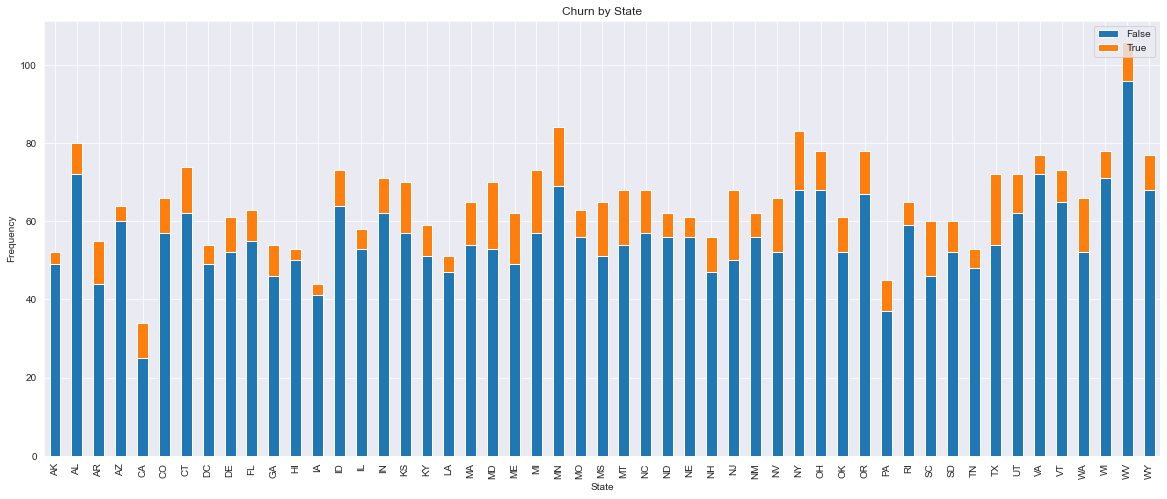

In [15]:
sns.set_style("darkgrid")
sns.color_palette("rocket", as_cmap=True)
fig, ax = plt.subplots(figsize=(20,8))

p = df.groupby(["state", "churn"]).size().unstack()
p.plot(ax=ax, kind='bar', stacked=True)
ax.set_title("Churn by State")
ax.set_ylabel("Frequency")
ax.set_xlabel("State")
plt.legend(loc='upper right');

Observations
- Higher churn in states like Maryland, New Jersey, and Texas.  
- Lower churn in states like Hawaii and Iowa.  

### Churn by International Plan

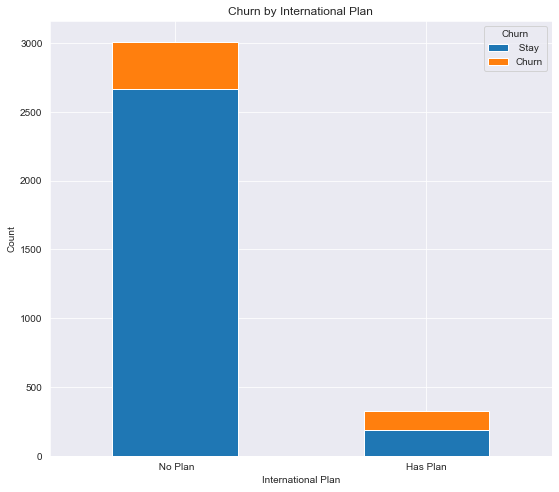

In [16]:
df2 = df.copy()
df2 = df.rename(columns={"churn":"Churn"})
df2['Churn'] = df2['Churn'].replace({False: " Stay", True: 'Churn'})
df2['international_plan'] = df2['international_plan'].replace({'no': " No Plan", 'yes': 'Has Plan'})
p = df2.groupby(["international_plan", "Churn"]).size().unstack()

sns.set_style("darkgrid")
sns.color_palette("rocket", as_cmap=True)
fig, ax = plt.subplots(figsize=(9,8))
p.plot(ax=ax, kind='bar', stacked=True)
ax.set_title("Churn by International Plan")
ax.set_ylabel("Count")
ax.set_xlabel("International Plan");
plt.xticks(rotation = 0);

Observations
- Churn is higher in customer with an international plan.

### Churn by Number of Service Calls

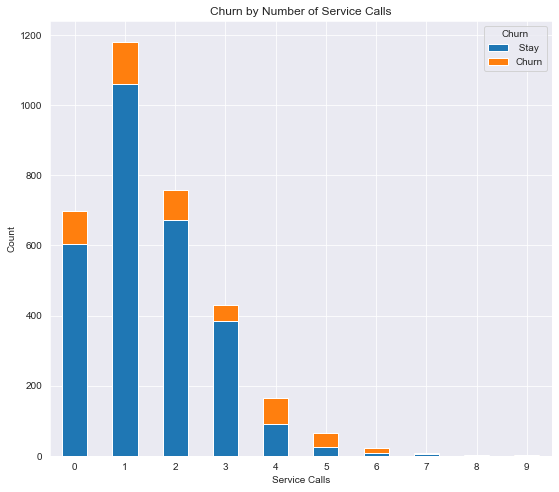

In [17]:
df2 = df.copy()
df2 = df.rename(columns={"churn":"Churn"})
df2['Churn'] = df2['Churn'].replace({False: " Stay", True: 'Churn'})
p = df2.groupby(["customer_service_calls", "Churn"]).size().unstack()

sns.set_style("darkgrid")
sns.color_palette("rocket", as_cmap=True)
fig, ax = plt.subplots(figsize=(9,8))
p.plot(ax=ax, kind='bar', stacked=True)
ax.set_title("Churn by Number of Service Calls")
ax.set_ylabel("Count")
ax.set_xlabel("Service Calls");
plt.xticks(rotation = 0);

Observations:
- Churn gets very high from 4 customer service calls.

## Modeling

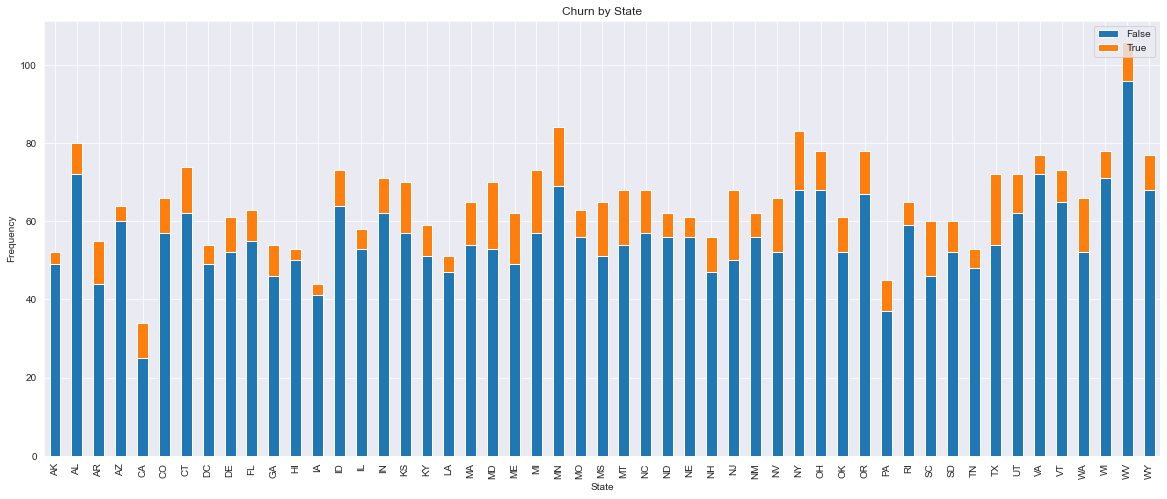

In [18]:
sns.set_style("darkgrid")
sns.color_palette("rocket", as_cmap=True)
fig, ax = plt.subplots(figsize=(20,8))

p = df.groupby(["state", "churn"]).size().unstack()
p.plot(ax=ax, kind='bar', stacked=True)
ax.set_title("Churn by State")
ax.set_ylabel("Frequency")
ax.set_xlabel("State")
plt.legend(loc='upper right')

### Baseline Model

#### Dummy Classifier

First step in modeling is to create a baseline model.  Common approach for this is to use the DummyClassifier estimator.

In [19]:
model_name = "Baseline - Dummy Classifer"
model = DummyClassifier(strategy='most_frequent', random_state=42)
pipe = Pipeline([ ('ct',CT), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)

Baseline - Dummy Classifer:
Training data - accuracy:          0.8555
Test data - accruacy:              0.8543
Classification report:
               precision    recall  f1-score   support

       False       0.85      1.00      0.92       997
        True       0.00      0.00      0.00       170

    accuracy                           0.85      1167
   macro avg       0.43      0.50      0.46      1167
weighted avg       0.73      0.85      0.79      1167



C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Round 1 - Simple Models (default hyperparameters)

Create simple models with default hyperparameters.  Since the column transformers will not change, all pipelines will be set up the same, while just swapping out the model type.

#### Logistic Regression Classifier

In [20]:
model_name = "Logistic Regression"
model = LogisticRegression(random_state=42)
pipe = Pipeline([ ('ct',CT), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)

Logistic Regression:
Training data - accuracy:          0.8569
Test data - accruacy:              0.8646
Classification report:
               precision    recall  f1-score   support

       False       0.88      0.97      0.92       997
        True       0.60      0.22      0.32       170

    accuracy                           0.86      1167
   macro avg       0.74      0.60      0.62      1167
weighted avg       0.84      0.86      0.84      1167



Results:
- The Logistic Regression Classifier did not improve the accuracy over the baseline model notably.
- Appears potentially underfit as the test data outperformed the training data.

#### Decision Tree Classifier

In [21]:
model_name = "Decision Tree Classifier"
model = DecisionTreeClassifier(random_state=42)
pipe = Pipeline([ ('ct',CT), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)

Decision Tree Classifier:
Training data - accuracy:          0.9031
Test data - accruacy:              0.9186
Classification report:
               precision    recall  f1-score   support

       False       0.96      0.95      0.95       997
        True       0.70      0.76      0.73       170

    accuracy                           0.92      1167
   macro avg       0.83      0.85      0.84      1167
weighted avg       0.92      0.92      0.92      1167



Results:
- This model improved the accuracy over the baseline model by ~6%.  
- Appears potentially underfit as the test data outperformed the training data.

#### KNearestNeighbors Classifier

In [22]:
model_name = "KNearestNeighbors Classifier"
model = KNeighborsClassifier()
pipe = Pipeline([('ct',CT), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)

KNearestNeighbors Classifier:
Training data - accuracy:          0.8818
Test data - accruacy:              0.88
Classification report:
               precision    recall  f1-score   support

       False       0.88      1.00      0.93       997
        True       0.92      0.19      0.32       170

    accuracy                           0.88      1167
   macro avg       0.90      0.60      0.63      1167
weighted avg       0.88      0.88      0.84      1167



Results:
- The KNN model improved the accuracy over the baseline model by ~3%.
- The model does not appear notably underfit or overfit.

#### Random Forest Classifier

In [23]:
model_name = "Random Forest Classifier"
model = RandomForestClassifier(random_state=42)
pipe = Pipeline([ ('ct',CT), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)

Random Forest Classifier:
Training data - accuracy:          0.9381
Test data - accruacy:              0.9383
Classification report:
               precision    recall  f1-score   support

       False       0.94      1.00      0.97       997
        True       0.96      0.60      0.74       170

    accuracy                           0.94      1167
   macro avg       0.95      0.80      0.85      1167
weighted avg       0.94      0.94      0.93      1167



Results:
- The Random Forest model improved the accuracy over the baseline model on test data by ~9%.  
- The model does not appear notably underfit or overfit.
- This is a top performing model.

#### GuassianNB Classifier

In [24]:
model_name = "GuassianNB Classifier"
model = GaussianNB()
pipe = Pipeline([ ('ct',CT), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)

GuassianNB Classifier:
Training data - accuracy:          0.5527
Test data - accruacy:              0.5758
Classification report:
               precision    recall  f1-score   support

       False       0.89      0.57      0.70       997
        True       0.19      0.60      0.29       170

    accuracy                           0.58      1167
   macro avg       0.54      0.59      0.49      1167
weighted avg       0.79      0.58      0.64      1167



Results:
- The Guassian NB model did not perform well. 

#### SVC Classifier

In [25]:
model_name = "SVC Classifier"
model = SVC(random_state=42)
pipe = Pipeline([ ('ct',CT), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)

SVC Classifier:
Training data - accuracy:          0.9017
Test data - accruacy:              0.9109
Classification report:
               precision    recall  f1-score   support

       False       0.91      0.99      0.95       997
        True       0.93      0.42      0.58       170

    accuracy                           0.91      1167
   macro avg       0.92      0.71      0.76      1167
weighted avg       0.91      0.91      0.90      1167



Results:
- The SVC model improved the accuracy over the baseline model on test data by 4-5%.  
- Appears potentially underfit as the test data outperformed the training data.

#### Gradient Booster Classifier

In [26]:
model_name = "Gradient Booster"
model = GradientBoostingClassifier(random_state=42)
pipe = Pipeline([ ('ct',CT), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)

Gradient Booster:
Training data - accuracy:          0.9451
Test data - accruacy:              0.952
Classification report:
               precision    recall  f1-score   support

       False       0.95      0.99      0.97       997
        True       0.94      0.72      0.81       170

    accuracy                           0.95      1167
   macro avg       0.95      0.85      0.89      1167
weighted avg       0.95      0.95      0.95      1167



Results:
- The Gradient Boosting Classifier improved the accuracy over the baseline model on test data by ~9%.  
- Appears potentially underfit as the test data outperformed the training data.
- This is a top performing model.

#### XGBoost Classifier

In [27]:
encoder = LabelEncoder()
y_train_xgb = pd.Series(encoder.fit_transform(y_train))
y_test_xgb = pd.Series(encoder.transform(y_test))

model_name = "XGBoost Classifier"
model = XGBClassifier(random_state=42)
pipe = Pipeline([ ('ct',CT), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train_xgb, X_test, y_test_xgb)

XGBoost Classifier:
Training data - accuracy:          0.9529
Test data - accruacy:              0.9529
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       997
           1       0.93      0.73      0.82       170

    accuracy                           0.95      1167
   macro avg       0.94      0.86      0.90      1167
weighted avg       0.95      0.95      0.95      1167



Results:
- The XGBoost Classifier improved the accuracy over the baseline model on test data by ~10%.  
- It does not appear to be notably underfit or overfit. 
- This is a top performing model.

#### Conclusion from Round 1
- The XGBoost, Gradient Booster, and Random Forest classifiers performed the best on test data. 

### Round 2 - Simple Models with Balanced Data

As we can see below, the target classes are pretty unbalanced (86%/14%).  In this section, I add SMOTE to the pipeline to see if we can get any better results with the simple models. 

In [28]:
y_train.value_counts()

False    1853
True      313
Name: churn, dtype: int64

In [29]:
y_train.value_counts(normalize=True)

False    0.855494
True     0.144506
Name: churn, dtype: float64

#### Baseline Model

In [30]:
model_name = "Baseline - Original"
model = DummyClassifier(strategy='most_frequent', random_state=42)
pipe = Pipeline([ ('ct',CT), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)

print("\n")
model_name = "Baseline - Balanced"
model = DummyClassifier(strategy='most_frequent', random_state=42)
pipe = ImPipeline([ ('ct',CT), ('sm1', SMOTE()), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)

Baseline - Original:
Training data - accuracy:          0.8555
Test data - accruacy:              0.8543
Classification report:
               precision    recall  f1-score   support

       False       0.85      1.00      0.92       997
        True       0.00      0.00      0.00       170

    accuracy                           0.85      1167
   macro avg       0.43      0.50      0.46      1167
weighted avg       0.73      0.85      0.79      1167





C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Baseline - Balanced:
Training data - accuracy:          0.8555
Test data - accruacy:              0.8543
Classification report:
               precision    recall  f1-score   support

       False       0.85      1.00      0.92       997
        True       0.00      0.00      0.00       170

    accuracy                           0.85      1167
   macro avg       0.43      0.50      0.46      1167
weighted avg       0.73      0.85      0.79      1167



C:\Users\natek\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results:
- Balancing the data did not change the results on the baseline model.  I'm not certain of the reason.  Moving on to see if balancing the data changes the results of the other models.  

#### Logistic Regression Classifier

In [31]:
model_name = "Logistic Regression - Original"
model = LogisticRegression(random_state=42, max_iter=200)
pipe = Pipeline([ ('ct',CT), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)

print("\n")
model_name = "Logistic Regression - Balanced"
model = LogisticRegression(random_state=42, max_iter=200)
pipe = ImPipeline([ ('ct',CT), ('sm1', SMOTE()), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)

Logistic Regression - Original:
Training data - accuracy:          0.8569
Test data - accruacy:              0.8646
Classification report:
               precision    recall  f1-score   support

       False       0.88      0.97      0.92       997
        True       0.60      0.22      0.32       170

    accuracy                           0.86      1167
   macro avg       0.74      0.60      0.62      1167
weighted avg       0.84      0.86      0.84      1167



Logistic Regression - Balanced:
Training data - accuracy:          0.7567
Test data - accruacy:              0.7635
Classification report:
               precision    recall  f1-score   support

       False       0.94      0.77      0.85       997
        True       0.35      0.72      0.47       170

    accuracy                           0.76      1167
   macro avg       0.65      0.75      0.66      1167
weighted avg       0.86      0.76      0.79      1167



Results:  
- Balancing the data decreased the accuracy of the model on test data.   

#### Decision Tree Classifier

In [32]:
model_name = "Decision Tree Classifier - Original"
model = DecisionTreeClassifier(random_state=42)
pipe = Pipeline([ ('ct',CT), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)

print("\n")
model_name = "Decision Tree Classifier - Balanced"
model = DecisionTreeClassifier(random_state=42)
pipe = ImPipeline([ ('ct',CT), ('sm1', SMOTE()), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)

Decision Tree Classifier - Original:
Training data - accuracy:          0.9031
Test data - accruacy:              0.9186
Classification report:
               precision    recall  f1-score   support

       False       0.96      0.95      0.95       997
        True       0.70      0.76      0.73       170

    accuracy                           0.92      1167
   macro avg       0.83      0.85      0.84      1167
weighted avg       0.92      0.92      0.92      1167



Decision Tree Classifier - Balanced:
Training data - accuracy:          0.885
Test data - accruacy:              0.9109
Classification report:
               precision    recall  f1-score   support

       False       0.96      0.93      0.95       997
        True       0.67      0.77      0.72       170

    accuracy                           0.91      1167
   macro avg       0.81      0.85      0.83      1167
weighted avg       0.92      0.91      0.91      1167



Results:
- Balancing the data slightly improved accuracy of the model on test data.   

#### KNearestNeighbors Classifier

In [33]:
model_name = "KNearestNeighbors Classifier - Original"
model = KNeighborsClassifier()
pipe = Pipeline([('ct',CT), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)

print("\n")
model_name = "KNearestNeighbors Classifier - Balanced"
model = KNeighborsClassifier()
pipe = ImPipeline([ ('ct',CT), ('sm1', SMOTE()), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)

KNearestNeighbors Classifier - Original:
Training data - accuracy:          0.8818
Test data - accruacy:              0.88
Classification report:
               precision    recall  f1-score   support

       False       0.88      1.00      0.93       997
        True       0.92      0.19      0.32       170

    accuracy                           0.88      1167
   macro avg       0.90      0.60      0.63      1167
weighted avg       0.88      0.88      0.84      1167



KNearestNeighbors Classifier - Balanced:
Training data - accuracy:          0.7419
Test data - accruacy:              0.7438
Classification report:
               precision    recall  f1-score   support

       False       0.94      0.75      0.83       997
        True       0.33      0.72      0.45       170

    accuracy                           0.74      1167
   macro avg       0.63      0.74      0.64      1167
weighted avg       0.85      0.74      0.78      1167



Results:
- Balancing the data decreased the accuracy of the model on test data.  

#### Random Forest Classifier

In [34]:
model_name = "Random Forest Classifier - Original"
model = RandomForestClassifier(random_state=42)
pipe = Pipeline([ ('ct',CT), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)

print("\n")
model_name = "Random Forest Classifier - Balanced"
model = RandomForestClassifier(random_state=42)
pipe = ImPipeline([ ('ct',CT), ('sm1', SMOTE()), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)

Random Forest Classifier - Original:
Training data - accuracy:          0.9381
Test data - accruacy:              0.9383
Classification report:
               precision    recall  f1-score   support

       False       0.94      1.00      0.97       997
        True       0.96      0.60      0.74       170

    accuracy                           0.94      1167
   macro avg       0.95      0.80      0.85      1167
weighted avg       0.94      0.94      0.93      1167



Random Forest Classifier - Balanced:
Training data - accuracy:          0.9326
Test data - accruacy:              0.9374
Classification report:
               precision    recall  f1-score   support

       False       0.95      0.98      0.96       997
        True       0.84      0.71      0.77       170

    accuracy                           0.94      1167
   macro avg       0.90      0.84      0.87      1167
weighted avg       0.93      0.94      0.94      1167



Results:
- Balancing the data did not notably increase the accuracy of the model on test data.  

#### GuassianNB Classifier

In [35]:
model_name = "GuassianNB Classifier - Original"
model = GaussianNB()
pipe = Pipeline([ ('ct',CT), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)


model_name = "GuassianNB Classifier - Balanced"
model = GaussianNB()
pipe = ImPipeline([ ('ct',CT), ('sm1', SMOTE()), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)

GuassianNB Classifier - Original:
Training data - accuracy:          0.5527
Test data - accruacy:              0.5758
Classification report:
               precision    recall  f1-score   support

       False       0.89      0.57      0.70       997
        True       0.19      0.60      0.29       170

    accuracy                           0.58      1167
   macro avg       0.54      0.59      0.49      1167
weighted avg       0.79      0.58      0.64      1167

GuassianNB Classifier - Balanced:
Training data - accuracy:          0.5508
Test data - accruacy:              0.5381
Classification report:
               precision    recall  f1-score   support

       False       0.88      0.53      0.66       997
        True       0.17      0.56      0.26       170

    accuracy                           0.54      1167
   macro avg       0.52      0.55      0.46      1167
weighted avg       0.77      0.54      0.61      1167



Results:
- Balancing the data decreased the accuracy of the model on test data.   

#### SVC Classifier

In [36]:
model_name = "SVC Classifier - Original"
model = SVC(random_state=42)
pipe = Pipeline([ ('ct',CT), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)

print("\n")
model_name = "SVC Classifier - Balanced"
model = SVC(random_state=42)
pipe = ImPipeline([ ('ct',CT), ('sm1', SMOTE()), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)

SVC Classifier - Original:
Training data - accuracy:          0.9017
Test data - accruacy:              0.9109
Classification report:
               precision    recall  f1-score   support

       False       0.91      0.99      0.95       997
        True       0.93      0.42      0.58       170

    accuracy                           0.91      1167
   macro avg       0.92      0.71      0.76      1167
weighted avg       0.91      0.91      0.90      1167



SVC Classifier - Balanced:
Training data - accuracy:          0.898
Test data - accruacy:              0.9075
Classification report:
               precision    recall  f1-score   support

       False       0.94      0.95      0.95       997
        True       0.68      0.68      0.68       170

    accuracy                           0.91      1167
   macro avg       0.81      0.81      0.81      1167
weighted avg       0.91      0.91      0.91      1167



Results:
- Balancing the data decreased the accuracy of the model on test data.  

#### Gradient Booster Classifier

In [37]:
model_name = "Gradient Booster - Original"
model = GradientBoostingClassifier(random_state=42)
pipe = Pipeline([ ('ct',CT), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)

print("\n")
model_name = "Gradient Booster - Balanced"
model = GradientBoostingClassifier(random_state=42)
pipe = ImPipeline([ ('ct',CT), ('sm1', SMOTE()), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train, X_test, y_test)

Gradient Booster - Original:
Training data - accuracy:          0.9451
Test data - accruacy:              0.952
Classification report:
               precision    recall  f1-score   support

       False       0.95      0.99      0.97       997
        True       0.94      0.72      0.81       170

    accuracy                           0.95      1167
   macro avg       0.95      0.85      0.89      1167
weighted avg       0.95      0.95      0.95      1167



Gradient Booster - Balanced:
Training data - accuracy:          0.9354
Test data - accruacy:              0.9409
Classification report:
               precision    recall  f1-score   support

       False       0.96      0.97      0.97       997
        True       0.82      0.76      0.79       170

    accuracy                           0.94      1167
   macro avg       0.89      0.87      0.88      1167
weighted avg       0.94      0.94      0.94      1167



Results:
- Balancing the data decreased the accuracy of the model on test data.

#### XGBoost Classifier

In [38]:
encoder = LabelEncoder()
y_train_xgb = pd.Series(encoder.fit_transform(y_train))
y_test_xgb = pd.Series(encoder.transform(y_test))

model_name = "XGBoost Classifier - Original"
model = XGBClassifier(random_state=42)
pipe = Pipeline([ ('ct',CT), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train_xgb, X_test, y_test_xgb)

print("\n")
model_name = "XGBoost Classifier - Balanced"
model = XGBClassifier(random_state=42)
pipe = ImPipeline([ ('ct',CT), ('sm1', SMOTE()), ('model', model) ])
cross_val_and_print_results_on_model(model_name, pipe, X_train, y_train_xgb, X_test, y_test_xgb)

XGBoost Classifier - Original:
Training data - accuracy:          0.9529
Test data - accruacy:              0.9529
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97       997
           1       0.93      0.73      0.82       170

    accuracy                           0.95      1167
   macro avg       0.94      0.86      0.90      1167
weighted avg       0.95      0.95      0.95      1167



XGBoost Classifier - Balanced:
Training data - accuracy:          0.9497
Test data - accruacy:              0.9589
Classification report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       997
           1       0.92      0.79      0.85       170

    accuracy                           0.96      1167
   macro avg       0.94      0.89      0.91      1167
weighted avg       0.96      0.96      0.96      1167



Results:
- Balancing the data slightly improved the accuracy of the model on test data.  

#### Conclusion from Round 2
- Using SMOTE to balance the data did not notably improve any of the models performance, and in fact it decreased the performance of most of the models.  It appears that using data as is (86/14 split) is not that bad for the models.  This would align with the 90/10 split threshold discussed during our class.  As such, I will not use SMOTE going forward in the next round of modeling.  

### Round 3 - Hyperparameter Tuning the 3 Best Performing Models

#### XGBoost Classifier

**Create the model and pipeline**

In [39]:
# Transform y-train and y-test based using LabelEncoder
# This is specific to XGBoost
encoder = LabelEncoder()
y_train_xgb = pd.Series(encoder.fit_transform(y_train))
y_test_xgb = pd.Series(encoder.transform(y_test))

model_name = "XGBoost Classifier"
model = XGBClassifier(random_state=42)
pipe = Pipeline([('ct',CT),
                 ('model', model) 
])

**Round 1 of Gridsearching on XGBoost Classifer (try parameters to the left and right of defaults)**

In [40]:
parameters = {'model__learning_rate':[.1, .3, .5],          # default is 0.3 
              'model__max_depth': [4, 6, 8],                # default is 6    
              'model__min_child_weight': [0, 1, 2],         # default is 1    
              'model__subsample': [.75, 1.0]                # default is 1   
             }
grid_search_and_print_results(parameters, pipe, X_train, y_train_xgb, X_test, y_test_xgb)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:   48.6s finished


Results:
- Best params:  {'model__learning_rate': 0.5, 'model__max_depth': 6, 'model__min_child_weight': 0, 'model__subsample': 1.0}
- Best score:  0.9547588893264226
- Test data score:  0.9562982005141388


Results:
- Pretty good results. Accuracy is at 96% (round to the nearest %).

**Round 2 of Gridsearching on XGBoost Classifer (adjusted from round 1 gridsearch)**

In [41]:
parameters = {'model__learning_rate':[.4, .5, .6],            
              'model__max_depth': [5, 6, 7],                 
              'model__min_child_weight': [0, .25, .5],      
              'model__subsample': [.8, .9, 1.0]                 
             }
grid_search_and_print_results(parameters, pipe, X_train, y_train_xgb, X_test, y_test_xgb)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 405 out of 405 | elapsed:  1.3min finished


Results:
- Best params:  {'model__learning_rate': 0.4, 'model__max_depth': 7, 'model__min_child_weight': 0, 'model__subsample': 1.0}
- Best score:  0.9561392492629921
- Test data score:  0.9545844044558698


Results:
- Adjusting the model did worse.  Let's go with the parameters we found from Round 1 Gridsearch.  

#### Gradient Booster Classifier

**Create the model and pipeline**

In [42]:
model_name = "Gradient Booster"
model = GradientBoostingClassifier(random_state=42)
pipe = Pipeline([ ('ct', CT), ('model', model) ])

**Round 1 of Gridsearching on Gradient Booster Classifier (try parameters to the left and right of defaults)**

In [43]:
parameters = {'model__n_estimators':[50, 100, 200],                      # default is 100
              'model__learning_rate':[.1, .3],                           # default is 0.1 
              'model__max_depth': [1, 3, 4],                             # default is 3 
              'model__subsample': [.6, .8, 1.0]                          # default is 1   
             }

grid_search_and_print_results(parameters, pipe, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  2.1min finished


Results:
- Best params:  {'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 100, 'model__subsample': 1.0}
- Best score:  0.9510648034822958
- Test data score:  0.9502999143101971


Results:
- Model did ok.  Did not do better than XGBoost.  Let's try one more round of gradient boosting classifier.

**Round 2 of Gridsearching on Gradient Booster Classifier (adjusted from prior gridsearch)**

In [44]:
parameters = {'model__n_estimators':[100],                                # default is 100
              'model__learning_rate':[.1, .2],                            # default is 0.1 
              'model__max_depth': [4, 6, 8],                              # default is 3 
              'model__subsample': [.9, 1.0]                               # default is 1   
             }

grid_search_and_print_results(parameters, pipe, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  1.0min finished


Results:
- Best params:  {'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 100, 'model__subsample': 1.0}
- Best score:  0.9510648034822958
- Test data score:  0.9502999143101971


Results:
- Did not improve the results.  XGBoost is still the best performing.  Let's try Random Forest Classifier. 

#### Random Forest Classifier

**Create the model and pipeline**

In [45]:
model_name = "Random Forest Classifier"
model = RandomForestClassifier(random_state=42)
pipe = Pipeline([('ct',CT),
                 ('model', model) 
])

**Round 1 of Gridsearching on Random Forest Classifier (try parameters to the left and right of defaults)**

In [46]:
parameters = {'model__n_estimators':[50, 100, 200],                       # default is 100
              'model__max_depth': [None, 3, 6, 9],                        # default is None
              'model__criterion': ['gini', 'entropy'],                    # default is gini
              'model__min_samples_split': [1.0, 3, 5]                     # default is 1
             }
grid_search_and_print_results(parameters, pipe, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  1.3min finished


Results:
- Best params:  {'model__criterion': 'gini', 'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 100}
- Best score:  0.935827630612701
- Test data score:  0.9451585261353899


Results:
- Did not outperform the best model, XGBoost.  

#### Conclusion from Round 3
- XGBoost was the model with the best accuracy on test data using gridsearching.

### Best Model

#### XGBoost (Best Hyperparameters from Gridsearch)

In [47]:
# Transform y-train and y-test based using LabelEncoder
# This is specific to XGBoost
encoder = LabelEncoder()
y_train_xgb = pd.Series(encoder.fit_transform(y_train))
y_test_xgb = pd.Series(encoder.transform(y_test))

model_name = "XGBoost Classifier"
model = XGBClassifier(random_state=42)
pipe = Pipeline([('ct',CT),
                 ('model', model) 
])

parameters = {'model__learning_rate':[.5],          
              'model__max_depth': [6],                 
              'model__min_child_weight': [0],        
              'model__subsample': [1.0]}           
              
grid_search_and_print_results(parameters, pipe, X_train, y_train_xgb, X_test, y_test_xgb)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Results:
- Best params:  {'model__learning_rate': 0.5, 'model__max_depth': 6, 'model__min_child_weight': 0, 'model__subsample': 1.0}
- Best score:  0.9547588893264226
- Test data score:  0.9562982005141388


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished


## Evaluation / Results

**High churn groups**
- Higher churn was identified in states like Maryland, New Jersey, and Texas.  It was also identified in customers with international plans and customers with 5 or more customer service calls.  Recommend SyriaTel looking into world drivers of these identified issues.

**Classification model:**
- XGBoost was the model with the best accuracy on unseen test data.  It performed with an accuracy of 96%.  It is recommended that SyriaTel implement this model in its active marketing strategy to prevent loss of customers.  

## Next Steps

- **More customer data:** We were able to create a model with 96% accuracy on limited data.  The more data that can be provided (data on more customers or additional data on each customer), it is possible we can improve the model's accuracy further.  


- **Customer retention plan:** Once you know which customers are at risk of leaving, you should have a plan for what you will offer them to stay that both minimizes the cost of retention but also alleviates their risk of leaving.    